In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [1]:
import pandas as pd
import os
import re
import codecs
from IPython.display import display
from six.moves import cPickle as pickle
import string
from PIL import Image
import numpy as np
import h5py
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
width = None
pd.options.display.max_rows = 600
pd.options.display.max_columns = width
pd.options.display.max_colwidth = 600
pd.options.display.width = width
pd.options.display.max_seq_items = None
pd.options.display.expand_frame_repr = False
pd.options.display.colheader_justify = 'left'

In [3]:
import data_commons as dtc
import dl_commons as dlc
import viz_commons as vc
from viz_commons import VisualizeDir, DiffParams, VisualizeStep

Using TensorFlow backend.


In [4]:
# v = Visualize('./tb_metrics_dev/2017-10-06 17-56-47 PDT/store', '../data/generated2')
# v = VisualizeDir('./tb_metrics/2017-10-08 12-26-45 PDT/store')
# v = VisualizeDir('./tb_metrics_dev/2017-10-09 12-45-15 PDT/store')
# vd = VisualizeDir('./tb_metrics/2017-10-09 17-43-49 PDT/store')
# vd = VisualizeDir('tb_metrics/2017-10-09 16-01-07 PDT/store')
# vd2 = VisualizeDir('tb_metrics/2017-09-26 22-40-18 PDT/new_code 2017-10-10 15-10-17 PDT/store')
# vd = VisualizeDir('./tb_metrics/2017-10-07 14-33-35 PDT_my_decoder/store')
# vd = VisualizeDir('./tb_metrics_view/2017-10-10 19-14-54 PDT good 3_decoder_LSTMs_my_decoder/store')
# vd = VisualizeDir('./tb_metrics_view/2017-10-11 17-46-12 PDT 3lstm_3att/store')
# vd = VisualizeDir('/zpool_3TB/i2l/tb_metrics/2017-10-12 00-15-53 PDT good 3lstm_attMLP/store')
# vd = VisualizeDir('./tb_metrics_view/2017-10-12 19-06-32 PDT 3.1LSTM_noShare_3att/store')
# vd = VisualizeDir('./tb_metrics_view/2017-10-17 15-41-15 PDT 3.1LSTM_3att_noGather/store_2')
# vd = VisualizeDir('./tb_metrics_dev/2017-10-19 00-08-10 PDT reset/store')
# vd = VisualizeDir('./tb_metrics/2017-10-19 22-21-59 PDT reset_3.1LSTM_2init_3out_3att/store')
vd = VisualizeDir('/zpool_3TB/i2l/tb_metrics/2017-10-20 23-45-40 PDT reset_3.1LSTM_2init_3out_3attConv_1beta/snapshot-00078736/store_2')
# vd = VisualizeDir('./tb_metrics_dev/validate_154364/store_6')

In [5]:
# vd.test_alpha_viz()

In [6]:
# display(vd.max_steps)
# display(vd2.max_steps)\omega _{\mu \nu }=\partial _{\mu }v_{\nu }-\partial _{\nu }v_{\mu }

In [7]:
vs = VisualizeStep(vd, 'validation', 78736)
vs.strs('predicted_ids', 'y', mingle=False)

,edit_distance,predicted_ids,y
31,0.085714,"\overline {q}=q_4e_4-q_me_m\equiv q_4-\mathbf {q},\label {6.23}\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1","\overline {q}=q_4e_4-q_me_m\equiv q_4-\mathbf {q},\label {153}\eos \eos \eos \eos \eos \eos \eos"
78,0.103448,\omega _{\mu }=\partial _{\mu }u_{\nu }-\partial _{\nu }\omega _{\mu }\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-2-2-2,\omega _{\mu \nu }=\partial _{\mu }v_{\nu }-\partial _{\nu }v_{\mu }\eos \eos \eos \eos \eos \eos \eos \eos \eos \eos \eos \eos \eos
76,0.111111,"\sum _iq_a^i|X_i|^2=R_a;\qquad a=1,...,r.\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-2-2-2","\label {2}\sum _iq_a^i|X_i|^2=R_a;\qquad a=1,...,r.\eos \eos \eos \eos \eos \eos"
15,0.242424,A_\mu (x)=A_\mu (x)+\partial _\mu \lambda (x)\label {25}\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1,A_\mu ^{\prime }(x)=A_\mu (x)+\partial _\mu \Lambda (x)\label {2.cc}\eos \eos \eos \eos \eos \eos \eos \eos \eos
28,0.342857,\tau =\frac {\theta }{8\pi }+\frac {4\pi i}{g^2}.\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1,\label {eq:tau}\tau =\frac {\theta }{2\pi }+\frac {4\pi i}{g^{2}}.\eos \eos \eos \eos \eos \eos \eos
73,0.388889,"\frac {1}{2}\phi ^2-\frac {2}{(eF-y^2)^2},\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-2-2-2","{\frac {1}{2}\dot {\phi }^2=\frac {2}{\alpha ^2(t-t_0)^2},}\eos \eos \eos \eos \eos \eos"
24,0.390244,"{\bar g}_{\mu \nu }=g_{\mu \nu }-2\bar \pi B\partial _i\Phi \partial _j\Phi ,\label {eq:7}\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1","\hat {g}_{\mu \nu }=g_{\mu \nu }-B\partial _{\mu }\Phi \partial _{\nu }\Phi ,\label {metrel}\eos"
60,0.400000,"\sigma ^{\left (n\right )}\cdot \gamma ^{\gamma }=\frac {1}{2}\epsilon ^{\mu \nu \alpha \beta }F_{\beta \gamma },\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-2-2-2","\sigma ^{\kappa \rho }\gamma ^{5}=\frac {1}{2}\epsilon ^{\kappa \rho \tau \sigma }\sigma _{\tau \sigma },\eos \eos \eos \eos \eos \eos \eos"
56,0.424242,"T(z)=\tilde T(\bar z),\qquad {\rm in\}(X)=0.\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-2-2-2","T(z)=\tilde T(z),\qquad {\rm Im}(z)=0.\label {tbound}\eos \eos \eos \eos \eos \eos \eos \eos \eos"
29,0.485714,"{\cal F}=\{F(\partial )U(4),\psi (\sigma )\}\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1","{\cal F}=\{\Psi [X(\sigma );c(\sigma ),b(\sigma )]\}\label {funct}\eos \eos \eos \eos \eos \eos \eos"


In [7]:
from IPython.display import Latex
Latex(r"""
\begin{eqnarray}
\overline {q}=q_4e_4-q_me_m\equiv q_4-\mathbf {q},\label {6.23}
\end{eqnarray}
""")

<IPython.core.display.Latex object>

$\overline {q}=q_4e_4-q_me_m\equiv q_4-\mathbf {q},$

In [8]:
from IPython.display import Math
Math(r'\overline {q}=q_4e_4-q_me_m\equiv q_4-\mathbf {q},')

<IPython.core.display.Math object>

In [13]:
df_strs = vs.strs('predicted_ids', 'y', mingle=False)
display(df_strs)

,edit_distance,predicted_ids,y
31,0.085714,"\overline {q}=q_4e_4-q_me_m\equiv q_4-\mathbf {q},\label {6.23}\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1","\overline {q}=q_4e_4-q_me_m\equiv q_4-\mathbf {q},\label {153}\eos \eos \eos \eos \eos \eos \eos"
78,0.103448,\omega _{\mu }=\partial _{\mu }u_{\nu }-\partial _{\nu }\omega _{\mu }\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-2-2-2,\omega _{\mu \nu }=\partial _{\mu }v_{\nu }-\partial _{\nu }v_{\mu }\eos \eos \eos \eos \eos \eos \eos \eos \eos \eos \eos \eos \eos
76,0.111111,"\sum _iq_a^i|X_i|^2=R_a;\qquad a=1,...,r.\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-2-2-2","\label {2}\sum _iq_a^i|X_i|^2=R_a;\qquad a=1,...,r.\eos \eos \eos \eos \eos \eos"
15,0.242424,A_\mu (x)=A_\mu (x)+\partial _\mu \lambda (x)\label {25}\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1,A_\mu ^{\prime }(x)=A_\mu (x)+\partial _\mu \Lambda (x)\label {2.cc}\eos \eos \eos \eos \eos \eos \eos \eos \eos
28,0.342857,\tau =\frac {\theta }{8\pi }+\frac {4\pi i}{g^2}.\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1,\label {eq:tau}\tau =\frac {\theta }{2\pi }+\frac {4\pi i}{g^{2}}.\eos \eos \eos \eos \eos \eos \eos
73,0.388889,"\frac {1}{2}\phi ^2-\frac {2}{(eF-y^2)^2},\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-2-2-2","{\frac {1}{2}\dot {\phi }^2=\frac {2}{\alpha ^2(t-t_0)^2},}\eos \eos \eos \eos \eos \eos"
24,0.390244,"{\bar g}_{\mu \nu }=g_{\mu \nu }-2\bar \pi B\partial _i\Phi \partial _j\Phi ,\label {eq:7}\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1","\hat {g}_{\mu \nu }=g_{\mu \nu }-B\partial _{\mu }\Phi \partial _{\nu }\Phi ,\label {metrel}\eos"
60,0.400000,"\sigma ^{\left (n\right )}\cdot \gamma ^{\gamma }=\frac {1}{2}\epsilon ^{\mu \nu \alpha \beta }F_{\beta \gamma },\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-2-2-2","\sigma ^{\kappa \rho }\gamma ^{5}=\frac {1}{2}\epsilon ^{\kappa \rho \tau \sigma }\sigma _{\tau \sigma },\eos \eos \eos \eos \eos \eos \eos"
56,0.424242,"T(z)=\tilde T(\bar z),\qquad {\rm in\}(X)=0.\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-2-2-2","T(z)=\tilde T(z),\qquad {\rm Im}(z)=0.\label {tbound}\eos \eos \eos \eos \eos \eos \eos \eos \eos"
29,0.485714,"{\cal F}=\{F(\partial )U(4),\psi (\sigma )\}\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1","{\cal F}=\{\Psi [X(\sigma );c(\sigma ),b(\sigma )]\}\label {funct}\eos \eos \eos \eos \eos \eos \eos"


edit_distance                                                                                                                                                                           0.103448
predicted_ids    \omega _{\mu }=\partial _{\mu }u_{\nu }-\partial _{\nu }\omega _{\mu }\eos -1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-2-2-2
y                                                          \omega _{\mu \nu }=\partial _{\mu }v_{\nu }-\partial _{\nu }v_{\mu }\eos \eos \eos \eos \eos \eos \eos \eos \eos \eos \eos \eos \eos 
Name: 78, dtype: object


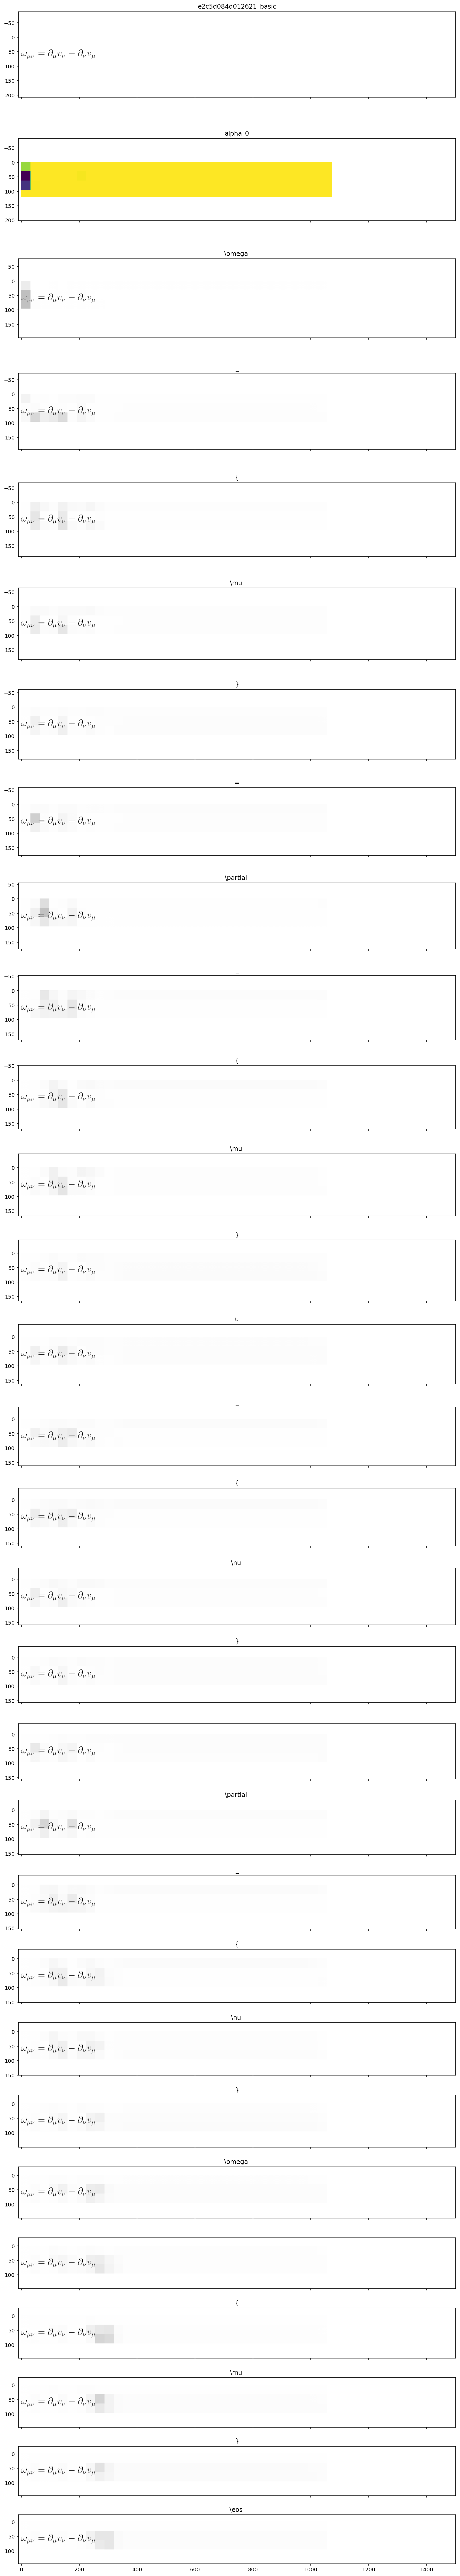

In [16]:
image_data = vs.alpha(sample_num=1)